In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [2]:
flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])

t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak']

### Importing in GJ1243 light curve (DR-25)

In [3]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX)
    except:
            print(q)

### Masking out the flares

In [4]:
f_mask = np.zeros_like(gj1243lc.time, dtype=bool)
for i in range(len(t_starts)):
    dur = t_stops[i] - t_starts[i]
    c1 = 0.25
    c2 = 0.5  
    buffer = (gj1243lc.time >= t_starts[i] - c1*dur) & (gj1243lc.time <= t_stops[i] + c2*dur)
    temp = (gj1243lc.time >= t_starts[i]) & (gj1243lc.time <= t_stops[i])
    f_mask = f_mask + buffer
print(f_mask)
no_flares = np.where((f_mask == False))[0]

[False False False ... False False False]


In [5]:
f_mask

array([False, False, False, ..., False, False, False])

Text(0.5, 0, 'Time - 2457000 [BTJD days]')

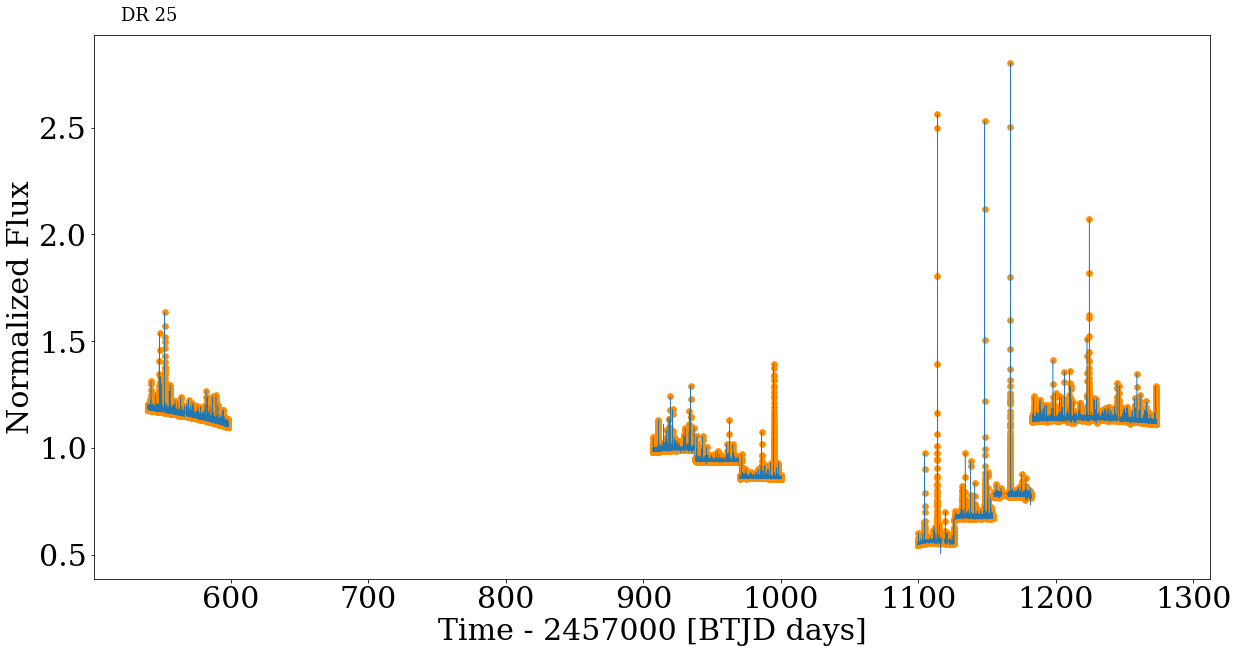

In [6]:
flares_x=gj1243lc.time[f_mask]
flares_y = gj1243lc.flux[f_mask]/np.nanmedian(gj1243lc.flux)

fig = plt.figure(figsize=(20,10))
import matplotlib
matplotlib.rcParams.update({'font.size':30})
matplotlib.rcParams.update({'font.family':'serif'})

fig.subplots_adjust(hspace=0.3, wspace=0.4)



plt.plot(gj1243lc.time[:84887],gj1243lc.flux[:84887]/np.nanmedian(gj1243lc.flux),linewidth=0.5,alpha=0.99,color='C0')
plt.plot(gj1243lc.time[84888:217976],gj1243lc.flux[84888:217976]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)
plt.plot(gj1243lc.time[217976:],gj1243lc.flux[217976:]/np.nanmedian(gj1243lc.flux),linewidth=0.5,color='C0',alpha=0.99)


plt.scatter(flares_x,flares_y,linewidth=0.7,color='darkorange',s=35)



#Text
plt.text(520, 3, 'DR 25', fontsize=18, color ='k')


plt.ylabel("Normalized Flux")
plt.xlabel("Time - 2457000 [BTJD days]")


#plt.savefig('gj1243_keplerlc.pdf',dpi=300, bbox_inches='tight', pad_inches=0.5)

### Accounting for quarterly discontinuities

In [7]:
i = 0
#month1_median = np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes])
total_median = np.nanmedian(gj1243lc.flux[no_flares])

#month1_flux = 1 + (gj1243_collection[i].PDCSAP_FLUX.flux[no_flare_un_mes] - month1_median) / total_median

raw_flux = 1+((gj1243lc.flux - total_median)/total_median)

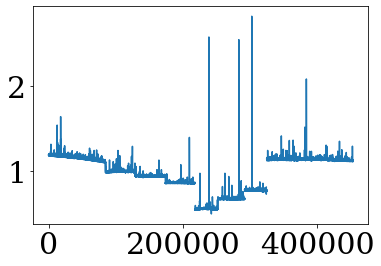

In [8]:
plt.plot(raw_flux)

In [49]:
quarter = (np.where(gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) and 
           np.where(gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))

#print(np.where(gj1243lc.time[no_flares] >= np.min(gj1243_collection[i].time)) and 
#np.where(gj1243lc.time[no_flares] <= np.max(gj1243_collection[i].time)))
print (quarter)
#print(gj1243_collection[0].time[no_flares[quarter]])



(array([     0,      1,      2, ..., 261631, 261632, 261633]),)


In [26]:
print(gj1243_collection[i].PDCSAP_FLUX.flux[no_flares][quarter])

IndexError: index 39123 is out of bounds for axis 0 with size 39123

In [40]:
#Do the times also need to be looped through in gp or is setting the quarterly med_fluxes enough?
#quarter_times=np.array([])
#for i in range (0,len(gj1243_collection[i].time[quarter])):
    #quarter_times = gj1243_collection[i].time[quarter]
    #print(i)

In [42]:
medflux=np.array([])
for i in range(0,len(gj1243_collection)):
    try:
        med = 1+((gj1243_collection[i].PDCSAP_FLUX.flux[no_flares] - np.nanmedian(gj1243_collection[i].PDCSAP_FLUX.flux[no_flares][quarter]))/total_median)
        medflux = np.append(medflux,med)
    except:
            print(i)

0
1
2
3
4
5
6
7
8
9
10


ValueError: x and y must have same first dimension, but have shapes (453357,) and (0,)

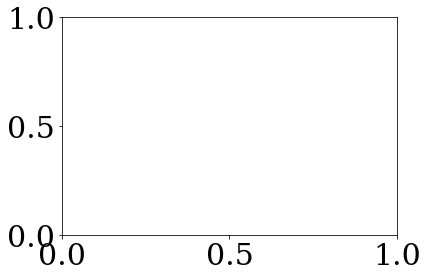

In [25]:
plt.plot(gj1243lc.time,medflux)
plt.xlim(540,600)
plt.ylim(0.9,1.2)

### Running the Gaussian Process

In [ ]:
import celerite
y = med_flux
t = gj1243lc.time[no_flares]
yerr = 1+((gj1243lc.flux_err[no_flares] - np.nanmedian(gj1243lc.flux[no_flares]))/(np.nanmedian(gj1243lc.flux[no_flares])))
yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)


# A non-periodic component
Q = 0.001
w0 = 2*np.pi/0.59
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)
#kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

In [ ]:
import celerite
from scipy.optimize import minimize

for i in range (0,len(medflux)):
        try:
            y = med_flux[i]
            t = gj1243lc.time[no_flares]
            yerr = 1+((gj1243lc.flux_err[no_flares] - np.nanmedian(gj1243lc.flux[no_flares]))/(np.nanmedian(gj1243lc.flux[no_flares])))
            yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
            Q = 0.001
            w0 = 2*np.pi/0.59
            S0 = np.var(y) / (w0 * Q)
            bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
            kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)
            gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
            gp.compute(t, yerr)  # You always need to call compute once.
            
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)
            initial_params = gp.get_parameter_vector()
            bounds = gp.get_parameter_bounds()
            r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
            gp.set_parameter_vector(r.x)
            #x= gj1243lc.time
            pred_mean, pred_var = gp.predict(y, x, return_var=True)
            pred_std = np.sqrt(pred_var)
        except:
            plt.errorbar(t,y,yerr=yerr)
            print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
            print(r)


In [ ]:
import celerite
from scipy.optimize import minimize

def gp(medflux):
    for i in range (0,len(medflux)):
        try:
            y = med_flux[i]
            t = gj1243lc.time[no_flares]
            yerr = 1+((gj1243lc.flux_err[no_flares] - np.nanmedian(gj1243lc.flux[no_flares]))/(np.nanmedian(gj1243lc.flux[no_flares])))
            yerr = np.sqrt(yerr**2 + np.nanmedian(pd.Series(y).rolling(10,center=True).std())**2)
            Q = 0.001
            w0 = 2*np.pi/0.59
            S0 = np.var(y) / (w0 * Q)
            bounds = dict(log_S0=(-15,15), log_Q=(-15,15), log_omega0=(-15,15))
            kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),bounds=bounds)
            gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
            gp.compute(t, yerr)  # You always need to call compute once.
        
        except:
            plt.errorbar(t,y,yerr=yerr)
            print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

In [ ]:
plt.errorbar(t,y,yerr=yerr)
plt.errorbar(t,y)

In [ ]:
gp = celerite.GP(kernel, mean=np.mean(y),fit_mean=True)
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

In [ ]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)


In [ ]:
#running pred_var takes a long time
x= gj1243lc.time
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

### Save gp values and plot outputs

In [ ]:
dict = {'time':x,'mean': pred_mean, 'std': pred_std, 'var': pred_var}  
gp_out = pd.DataFrame(dict) 
gp_out.to_csv(r'gp_values_mo.csv',header=True,index=True)

In [ ]:
#gp_vals=pd.read_csv('gp_values_11mo.csv')

In [ ]:
fig = plt.figure(figsize=(12,8))
font = {'size'   : 16}
plt.rc('font', **font)

color = "#ff7f0e"
#plt.plot(gj1243lc.time[no_flare],gj1243lc.flux[no_flare]/np.nanmedian(gj1243lc.flux),  lw=1, alpha=0.5)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(gp_vals['time'], gp_vals['mean'], color=color)
plt.fill_between(gp_vals['time'], gp_vals['mean']+gp_vals['std'], gp_vals['mean']-gp_vals['std'], color=color, alpha=0.5,
                 edgecolor="none",label='gp')
plt.xlabel("Time")
plt.ylabel("Flux")
#plt.xlim(549,552)
#plt.xlim(539.45,539.870)
plt.ylim(0.99,1.1)
plt.plot(gj1243lc.time[no_flares],medflux, lw=1,alpha=0.5,color='g',label='no_flares')
plt.plot(gj1243lc.time,raw_flux,label='raw_data')
plt.legend()

In [ ]:
detrended = (1+((gj1243lc.flux - np.nanmedian(gj1243lc.flux))/(np.nanmedian(gj1243lc.flux))))-gp_vals['mean']
plt.plot(gp_vals['time'],detrended_unmes)
plt.plot(un_mes.time,detrended_unmes)